In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

%matplotlib inline
sns.set(style='whitegrid')
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
def drop_columns(data):
    return data.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

data = yf.Ticker('MSFT')
df = drop_columns(data.history(start='2010-01-01'))
df.head()

,Close
Date,
2010-01-04,24.17
2010-01-05,24.18
2010-01-06,24.03
2010-01-07,23.78
2010-01-08,23.94


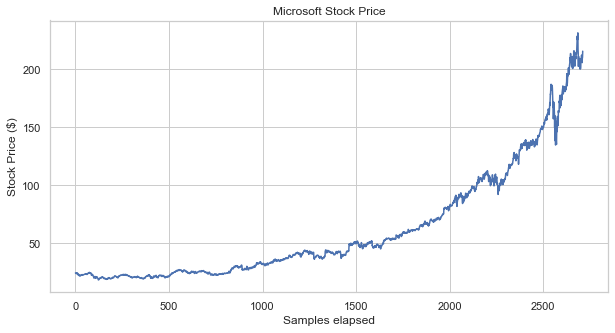

In [3]:
samples = np.arange(0, len(df), 1)
values = df['Close'].to_numpy()
plt.figure(figsize=(10,5))
plt.title('Microsoft Stock Price')
plt.plot(samples, values)
plt.xlabel('Samples elapsed')
plt.ylabel('Stock Price ($)')
plt.show()

In [4]:
df = pd.DataFrame(dict(price=values), index=samples, columns=['price'])

train_size = int(len(df)*0.7)
val_size = int(len(df)*0.2)
test_size = int(len(df)*0.1)

val_set = train_size + val_size
test_size = train_size + val_size + test_size
train, val, test = df.iloc[0:train_size], df.iloc[train_size:val_set], df.iloc[val_set:len(df)]
len(train), len(val), len(test)

(1898, 542, 272)

In [9]:
TIME_STEPS = 10
n_features = 1
n_seq = 2
n_steps = 2

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train, train.price, TIME_STEPS)
X_val, y_val = create_dataset(val, val.price, TIME_STEPS)
X_test, y_test = create_dataset(test, test.price, TIME_STEPS)

def generate_model():
    model = tf.keras.Sequential([
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(X_train.shape[0], n_steps, n_features)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
        tf.keras.layers.LSTM(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

model = generate_model()
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    verbose=1,
    shuffle=False,
    validation_data=(X_val, y_val)
)

Epoch 1/50


ValueError: in user code:

    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:176 assert_input_compatibility
        raise ValueError(&#39;Input &#39; + str(input_index) + &#39; of layer &#39; +

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [16, 10, 1]
